In [ ]:
from carabao.neuron import Cell,toy
from numpy import array,zeros

class Layer:
    def __init__(self,mon,G,K,P,xlabel=None):
        m,n,d,s = K.shape
        cells = []
        self.eta = 0.5             # synaptic threshold
        self.theta = 2             # spiking threshold
        self.delta = (0.2,0.2)     # learning deltas

           # build up FORTRAN order, so row index (i) must run faster
        
        for j in range(0,n):       # FORTRAN  order: column (j) index runs slower
            for i in range(0,m):   # and row index (i) runs faster
                k = j*m + i
                cell = Cell(mon,k,G[j],K[i,j],P[i,j])
                cell.syn.parameter(self.eta,self.theta,self.delta)
                cells.append(cell)
                
        self.cells = array([cells]).reshape(m,n,order='F')
        self.mon = mon
        self.mn = (m,n)
        self.xlabel = xlabel

    def phase(self,ph,u,c,subplot=0):
        m,n = self.mn
        for i in range(0,m):
            for j in range(0,n):
                c = self.cells[i,j].phase(ph,u[j],c)
        if subplot > 0:
            lay.plot(self.mon,subplot=subplot)
        return c

    def process(self,u,c,index=None,all=False):
        """
        Layer.process():  process one iteration step (all 4 phases) and plot
        >>> lay = Layer(mon,G,K,P)
        >>> lay.process(u,c)                 # silent processing (no logs)
        >>> lay.process(u,c,[[4]],label)     # change log of cell[4]
        >>> lay.process(u,c,[[4,5]],"",True) # log all of cell[4] and cell[5]
        """
        def log(phase,index,label,all):
            if isinstance(index,list) and len(index) > 0:
                self.log(index[phase],label,all)
        
        if index is not None:
            print("u:",u);  print("c:",c)
        log(0,index,"at begin",all)
            
        c = self.phase(1,u,c,subplot=1); 
        log(1,index,"after phase 1 (1st row): b = 0, y = u*x",all)
        
        c = self.phase(2,u,c)
        log(1,index,"after phase 2: b = u*(sum{v}==0)",all)

        #c = self.phase(3,u,c,subplot=2)
        c = self.phase(3,u,c)
        log(1,index,"after phase 3: y = u*(x|b), P' = sat(P+L(Z))",all)

        #c = self.phase(4,u,c,subplot=3)
        c = self.phase(4,u,c,subplot=2)
        log(1,index,"after phase 4 (2nd row): Z' = V(c);  x = max(S(c))",all)
        return c

    def log(self,index,label="",all=False):
        """
        Layer.log(): log a list of nodes
        >>> lay.log([5])                 # change log of cell[5]
        >>> lay.log([5],"before")        # change log cell[5] with label "before"
        >>> lay.log([1,2,3],"",all=True) # log all of cell[1],cell[2],cell[3]
        """
        #print("index:",index)
        for k in index:
            self.mon.log(self[k],"cell[%g] %s" % (k,label),all)

    
    def plot(self,mon,subplot=1):
        cells = self.cells; 
        m,n = self.mn;  mm,nn = self.mon.mn()
        oy = 5.55;  ox = -0.3
        for i in range(0,m):
            for j in range(0,n):
                x = j; y = i + (subplot-1)*2.3 - 0.5
                cell = cells[i,j]
                mon.plot(cell,y,x,index=cell.k)
                #mon.text(ox+x,oy-y,"%g" % (j*m+i),size=7)
        if self.xlabel is not None:
            for j in range(0,n):
                mon.xlabel(j,self.xlabel[j])

    def set_u(self,u):
        m,n = self.mn
        for i in range(0,m):
            for j in range(0,n):
                self.cells[i,j].set(u=u[j])

    def set(self,u=None):
        if u is not None: self.set_u(u)

    def connect(self,i,j,u,row=None):
        """
        Layer.connect(): setup connection topology and permanences for prediction
            lay.connect(i,j,row=1,u=token['likes'])
        """
        row = i if row is None else row
        cells = self.cells
        Kij = cells[i,j].syn.K
        Pij = cells[i,j].P*1.0
        m,n = cells.shape
        
        mu = 0;  nu = 0;  ii = row;
        for jj in range(0,len(u)):
            if u[jj] > 0:
                k = ii + m*jj
                Kij[mu,nu] = k
                Pij[mu,nu] = 0.5
                #print("Pij[%g,%g] ="%(mu,nu),Pij[mu,nu])
                nu += 1
        while nu < Kij.shape[1]:
            Pij[mu,nu] = 0.45;  nu += 1
        cells[i,j].syn.K = Kij
        cells[i,j].P = Pij
        print("connect => K%g:"%self.kappa(i,j),repr(cells[i,j].syn.K))
        print("connect => P%g:"%self.kappa(i,j),repr(cells[i,j].P))

    def __getitem__(self,k):
        i,j = self.kappa(k)
        return self.cells[i,j]
        
    def kappa(self,i,j=None):
        """
        Layer.kappa(): convert between matrix indices [i,j] and array index (k)
            k = layer.kappa(i,j)   # k = i+m*j
            i,j = layer.kappa(k)   # i = k % m, j = k // m
        """
        m,n = self.cells.shape
        if j is None:
            k = i;  return (k%m,k//m)
        else:
            return i + m*j
            

In [2]:
# layer: tiny HTM layer

from numpy import array,transpose
from carabao.neuron import toy
from carabao.util import repr
from carabao.screen import Monitor

G,K,P,c,token,xlabel,minicol = toy('tiny')
print("K:",K.shape,"P:",P.shape,"G:",G.shape)

height = 1+2.6*K.shape[0];  
height = 1+1.4*K.shape[0];  width = K.shape[1]


K: (2, 7, 2, 5) P: (2, 7, 2, 5) G: (7, 2)


connect => K4: #[0 12 2 3 4; 5 6 7 8 9]
connect => P4: #[0.5 0.5 0.45 0.45 0.45; 0 0 0 0 0]
u: [1, 0, 0, 0, 0, 0, 1]
c: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


AttributeError: 'Cell' object has no attribute 'Z'

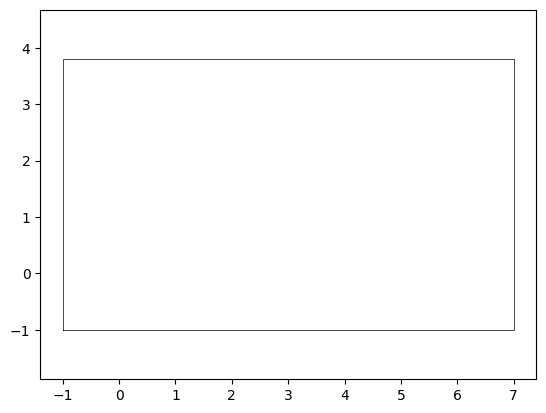

In [3]:
mon = Monitor(height,width)
lay = Layer(mon,G,K,P,xlabel=xlabel)

#===========================================================================
# let's go now and process sequence #0: 'Mary likes to sing'
#===========================================================================

seq = 0  # sequence number for 'Mary likes to sing' 
lay.connect(seq,minicol['likes'],token['Mary'])
c = lay.process(token['Mary'],c,[[0,4],[4],[4],[4],[0,4]])

connect => K6: #[4 12 2 3 4; 5 6 7 8 9]
connect => P6: #[0.5 0.5 0.45 0.45 0.45; 0 0 0 0 0]
u: [0, 0, 1, 0, 0, 0, 1]
c: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[4] at begin
--------------------------------------------------------------
   k4: 4 , g: [4 5] , eta: 0.5
   K4: [    0   12    2    3    4;     5    6    7    8    9]
   P4: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V4: [    1    1    0    0    0;     0    0    0    0    0]
   Z4: [    1    1    0    0    0;     0    0    0    0    0]
   W4: [    1    1    0    0    0;     0    0    0    0    0]
   E4: [    1    1    0    0    0;     0    0    0    0    0]
   S4: [    1    1    1    1    1;     0    0    0    0    0]
   b4: 0 , v4: [0 0]
   s4: [1 0] (||E||=2, theta:2)
   u4: 0 , y4: 0 , x4: 1
   c: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[4] after phase 1 (1st row): b = 0,

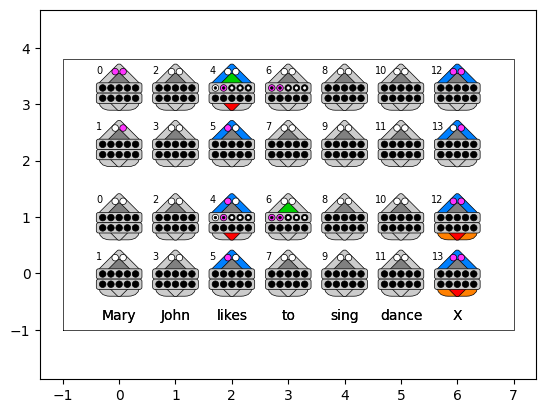

In [26]:
mon = Monitor(height,width)
lay.connect(seq,minicol['to'],token['likes'])
c = lay.process(token['likes'],c,[[4],[4],[4],[4],[4]])


connect => K8: #[6 12 2 3 4; 5 6 7 8 9]
connect => P8: #[0.5 0.5 0.45 0.45 0.45; 0 0 0 0 0]
u: [0, 0, 0, 1, 0, 0, 1]
c: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[6] at begin
--------------------------------------------------------------
   k6: 6 , g: [6 7] , eta: 0.5
   K6: [    4   12    2    3    4;     5    6    7    8    9]
   P6: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V6: [    1    1    0    0    1;     0    0    0    0    0]
   Z6: [    1    1    0    0    1;     0    0    0    0    0]
   W6: [    1    1    0    0    0;     0    0    0    0    0]
   E6: [    1    1    0    0    0;     0    0    0    0    0]
   S6: [    1    1    1    1    1;     0    0    0    0    0]
   b6: 0 , v6: [0 0]
   s6: [1 0] (||E||=2, theta:2)
   u6: 0 , y6: 0 , x6: 1
   c: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[6] after phase 1 (1st row): b = 0,

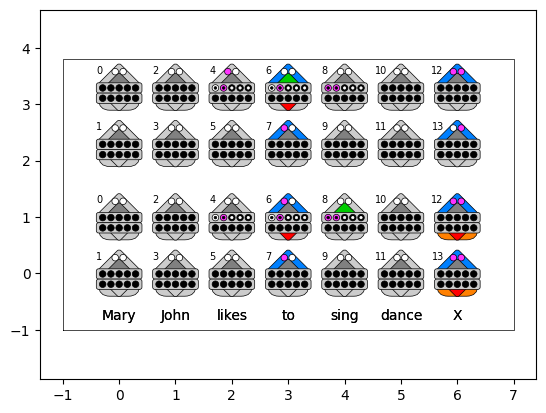

In [27]:
mon = Monitor(height,width)
lay.connect(seq,minicol['sing'],token['to'])
c = lay.process(token['to'],c,[[6],[6],[6],[6],[6]])


u: [0, 0, 0, 0, 1, 0, 1]
c: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[4] at begin
--------------------------------------------------------------
   k4: 4 , g: [4 5] , eta: 0.5
   K4: [    0   12    2    3    4;     5    6    7    8    9]
   P4: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V4: [    0    1    0    0    0;     0    1    0    0    0]
   Z4: [    0    1    0    0    0;     0    1    0    0    0]
   W4: [    1    1    0    0    0;     0    0    0    0    0]
   E4: [    0    1    0    0    0;     0    0    0    0    0]
   b4: 0 , v4: [0 0]
   s4: [0 0] (||E||=1, theta:2)
   u4: 0 , y4: 0 , x4: 0
   c: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[4] after phase 1 (1st row): b = 0, y = u*x
--------------------------------------------------------------
   u4: 0 , y4: 0 , x4: 0
---------------------------------------------------------

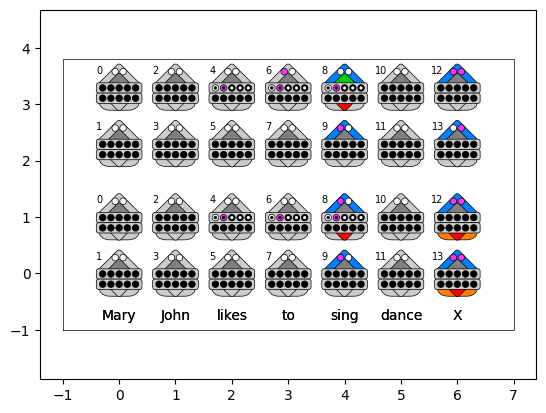

In [28]:
mon = Monitor(height,width)
c = lay.process(token['sing'],c,[[4],[4],[4],[4],[4]])


connect => K5: #[3 13 2 3 4; 5 6 7 8 9]
connect => P5: #[0.5 0.5 0.45 0.45 0.45; 0 0 0 0 0]
u: [0, 1, 0, 0, 0, 0, 1]
c: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[5] at begin
--------------------------------------------------------------
   k5: 5 , g: [4 5] , eta: 0.5
   K5: [    3   13    2    3    4;     5    6    7    8    9]
   P5: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V5: [    0    1    0    0    0;     0    0    0    1    0]
   Z5: [    0    0    0    0    0;     0    0    0    1    0]
   W5: [    1    1    0    0    0;     0    0    0    0    0]
   E5: [    0    1    0    0    0;     0    0    0    0    0]
   b5: 0 , v5: [0 0]
   s5: [0 0] (||E||=1, theta:2)
   u5: 0 , y5: 0 , x5: 0
   c: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[5] after phase 1 (1st row): b = 0, y = u*x
-----------------------------------------------------

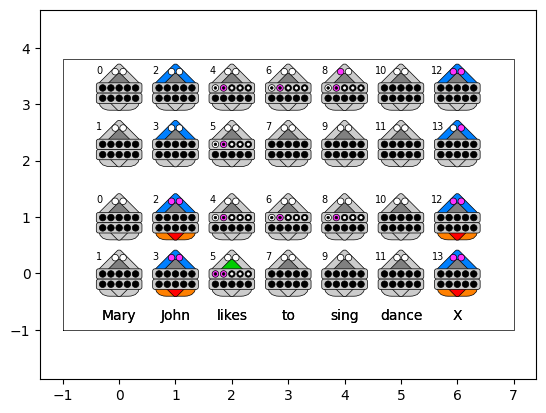

In [29]:
#===========================================================================
# let's process next sequence #1: 'John likes to dance'
#===========================================================================

seq = 1  # sequence number for 'John likes to dance'
mon = Monitor(height,width)
lay.connect(seq,minicol['likes'],token['John'])
c = lay.process(token['John'],c,[[5],[5],[5],[5],[5]])


connect => K7: #[5 13 2 3 4; 5 6 7 8 9]
connect => P7: #[0.5 0.5 0.45 0.45 0.45; 0 0 0 0 0]
u: [0, 0, 1, 0, 0, 0, 1]
c: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[7] at begin
--------------------------------------------------------------
   k7: 7 , g: [6 7] , eta: 0.5
   K7: [    5   13    2    3    4;     5    6    7    8    9]
   P7: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V7: [    0    1    1    1    0;     0    0    0    0    0]
   Z7: [    0    0    1    1    0;     0    0    0    0    0]
   W7: [    1    1    0    0    0;     0    0    0    0    0]
   E7: [    0    1    0    0    0;     0    0    0    0    0]
   b7: 0 , v7: [0 0]
   s7: [0 0] (||E||=1, theta:2)
   u7: 0 , y7: 0 , x7: 0
   c: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[7] after phase 1 (1st row): b = 0, y = u*x
-----------------------------------------------------

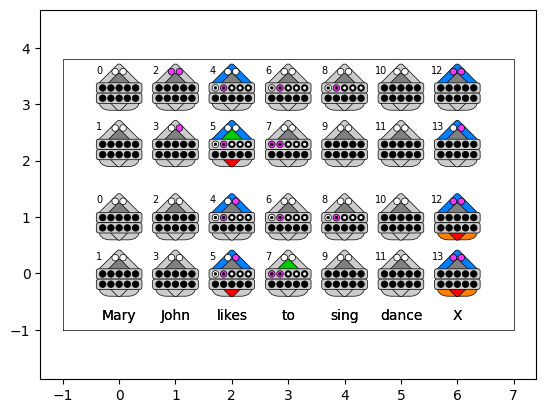

In [30]:
mon = Monitor(height,width)
lay.connect(seq,minicol['to'],token['likes'])
c = lay.process(token['likes'],c,[[7],[7],[7],[7],[7]])


connect => K11: #[7 13 2 3 4; 5 6 7 8 9]
connect => P11: #[0.5 0.5 0.45 0.45 0.45; 0 0 0 0 0]
u: [0, 0, 0, 1, 0, 0, 1]
c: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[11] at begin
--------------------------------------------------------------
   k11: 11 , g: [10 11] , eta: 0.5
   K11: [    7   13    2    3    4;     5    6    7    8    9]
   P11: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V11: [    0    1    0    0    0;     1    0    0    0    0]
   Z11: [    0    0    0    0    0;     1    0    0    0    0]
   W11: [    1    1    0    0    0;     0    0    0    0    0]
   E11: [    0    1    0    0    0;     0    0    0    0    0]
   b11: 0 , v11: [0 0]
   s11: [0 0] (||E||=1, theta:2)
   u11: 0 , y11: 0 , x11: 0
   c: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[11] after phase 1: b = 0, y = u*x
-------------------------------------------

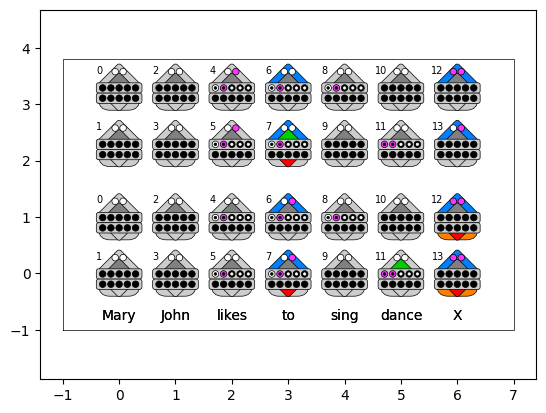

In [21]:
mon = Monitor(height,width)
lay.connect(seq,minicol['dance'],token['to'])
c = lay.process(token['to'],c,[[11],[11],[11],[11],[11]])


u: [0, 0, 0, 0, 0, 1, 1]
c: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[7] at begin
--------------------------------------------------------------
   k7: 7 , g: [6 7] , eta: 0.5
   K7: [    5   13    2    3    4;     5    6    7    8    9]
   P7: [  0.5  0.5  .45  .45  .45;     0    0    0    0    0]
   V7: [    0    1    0    0    0;     0    0    1    0    0]
   Z7: [    0    1    0    0    0;     0    0    1    0    0]
   W7: [    1    1    0    0    0;     0    0    0    0    0]
   E7: [    0    1    0    0    0;     0    0    0    0    0]
   b7: 0 , v7: [0 1]
   s7: [0 0] (||E||=1, theta:2)
   u7: 1 , y7: 1 , x7: 0
   c: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
--------------------------------------------------------------
cell[7] after phase 1: b = 0, y = u*x
--------------------------------------------------------------
   u7: 0 , y7: 0 , x7: 0
   c: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
------------------

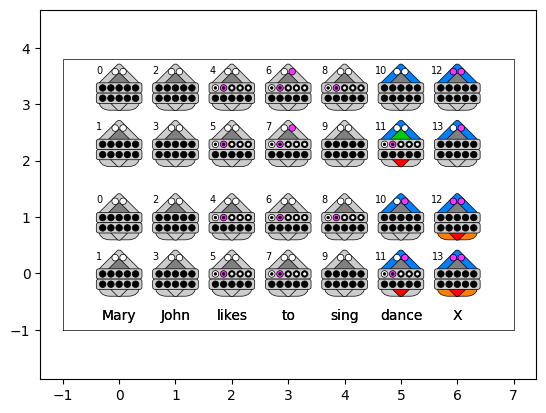

In [22]:
mon = Monitor(height,width)
c = lay.process(token['dance'],c,[[7],[7],[7],[7],[7]])
